# Deadlines

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

from src.utils.initialization import jobs_jssp_init as init, arrivals_init as term, gen_deadlines__prototype as gen_deadline

# Solver Model
import src.models.heuristics.fcfs as fcfs

# Extern
import pandas as pd

In [2]:
basic_data_path = get_path("data", "basic")
df_instance = pd.read_csv(basic_data_path / "instance.csv")
df_instance

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
...,...,...,...,...
95,9,5,M09,76
96,9,6,M05,47
97,9,7,M03,52
98,9,8,M04,90


In [3]:
df_jssp = init.generate_jobs_from_routings(df_instance)
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,0,0,M00,29
1,J25-0000,0,1,M01,78
2,J25-0000,0,2,M02,9
3,J25-0000,0,3,M03,36
4,J25-0000,0,4,M04,49
...,...,...,...,...,...
95,J25-0009,9,5,M09,76
96,J25-0009,9,6,M05,47
97,J25-0009,9,7,M03,52
98,J25-0009,9,8,M04,90


### a) Ankunftszeiten

In [4]:
mean_interarrival_time = term.calculate_mean_interarrival_time(df_instance, u_b_mmax =  0.90)
mean_interarrival_time

70.11

In [5]:
df_jobs = df_jssp[["Job", "Routing_ID"]].drop_duplicates()

arrivals = term.generate_arrivals_from_mean_interarrival_time(len(df_jobs), mean_interarrival_time)
df_jobs_arrivals = df_jobs.copy()
df_jobs_arrivals['Arrival'] = arrivals
df_jobs_arrivals

,Job,Routing_ID,Arrival
0,J25-0000,0,11
10,J25-0001,1,96
20,J25-0002,2,118
30,J25-0003,3,160
40,J25-0004,4,197
50,J25-0005,5,263
60,J25-0006,6,324
70,J25-0007,7,341
80,J25-0008,8,356
90,J25-0009,9,441


### b) Schedule

In [6]:
df_schedule = fcfs.schedule_with_arrivals(df_jssp, df_jobs_arrivals)
df_schedule


Schedule-Informationen:
  Makespan: 1371


,Job,Operation,Arrival,Machine,Start,Processing Time,End
0,J25-0000,0,11,M00,11,29,40
1,J25-0000,1,11,M01,40,78,118
2,J25-0000,2,11,M02,118,9,127
3,J25-0000,3,11,M03,127,36,163
4,J25-0000,4,11,M04,163,49,212
...,...,...,...,...,...,...,...
95,J25-0009,5,441,M09,1051,76,1127
96,J25-0009,6,441,M05,1127,47,1174
97,J25-0009,7,441,M03,1184,52,1236
98,J25-0009,8,441,M04,1236,90,1326


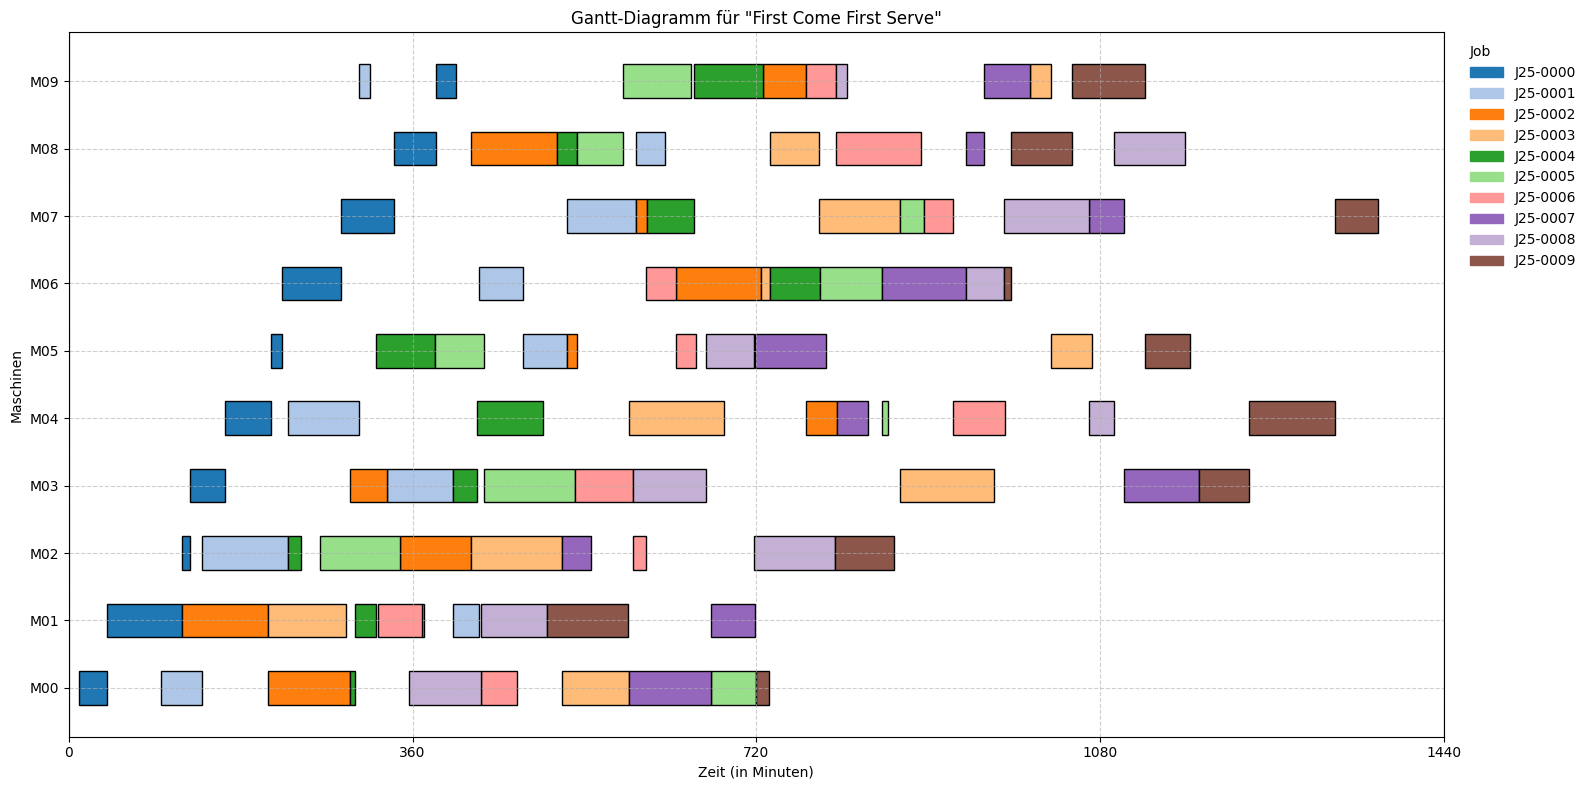

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.



True

In [7]:
category = "First Come First Serve"
show.plot_gantt(df_schedule, perspective="Machine", title='Gantt-Diagramm für "{}"'.format(category))

check.all_in_one(df_schedule)

## Deadlines

$$
{d_{j}=a_{j}+k\,p_{j}}
$$  

$$
S(k)=\frac{1}{n}\sum_{j=1}^{n}\mathbf{1}\!\bigl[C_{j}(k)\le d_{j}(k)\bigr]
$$  

$$
S(k)\;\ge\;S_{\text{target}}
$$  

---

* **$a_{j}$** – Ankunftszeit (Release-Date) von Job $j$  
* **$p_{j}$** – *Processing time* des Jobs (aus dem Job Shop Scheduling-Problem) 

  $$p_{j}=\sum_{(m,d)\in j} d$$  

  Summe aller Operationsdauern $d$ von Job $j$ über sämtliche Maschinen $m$.  
* **$k$** – Due-Date-Faktor, den die Binärsuche einstellt  
* **$d_{j}$** – zugewiesene Deadline für Job $j$  
* **$C_{j}(k)$** – Fertigstellzeit von Job $j$ im geplanten Schedule bei Faktor $k$  
* **$\mathbf{1}[\;\cdot\;]$** – Indikatorfunktion (1, wenn Aussage wahr; sonst 0)  
* **$S(k)$** – gemessener Service-Level (Anteil pünktlicher Jobs) bei Faktor $k$  
* **$S_{\text{target}}$** – gewünschter Mindest-Service-Level (z. B. $0{,}95$ - mindestens $95$% aller **Jobs** sollen ihre **Deadline** einhalten)  


In [8]:
k_opt, df_deadlines = gen_deadline._find_k(df_jssp, df_jobs_arrivals, fcfs.schedule_with_arrivals, target_service=0.95)
print(f"Gefundener Due-Date-Faktor k = {k_opt:.4f}")


Schedule-Informationen:
  Makespan: 1371
Gefundener Due-Date-Faktor k = 1.4722


In [9]:
df_jobs_times = df_jobs_arrivals.merge(df_deadlines, on='Job', how='left').sort_values('Arrival').reset_index(drop=True)
df_jobs_times

,Job,Routing_ID,Arrival,Deadline
0,J25-0000,0,11,592.527777
1,J25-0001,1,96,846.833333
2,J25-0002,2,118,954.222221
3,J25-0003,3,160,1124.305555
4,J25-0004,4,197,775.583333
5,J25-0005,5,263,993.222221
6,J25-0006,6,324,936.444444
7,J25-0007,7,341,1134.527777
8,J25-0008,8,356,1234.916666
9,J25-0009,9,441,1235.999999


In [10]:
# Check
df_temp = df_schedule.groupby('Job', as_index=False).agg(End=('End', 'max'))
df_jobs_times.merge(df_temp, on="Job").sort_values("Arrival")[["Job","Arrival", "End", "Deadline"]]

,Job,Arrival,End,Deadline
0,J25-0000,11,406,592.527777
1,J25-0001,96,624,846.833333
2,J25-0002,118,805,954.222221
3,J25-0003,160,1072,1124.305555
4,J25-0004,197,787,775.583333
5,J25-0005,263,896,993.222221
6,J25-0006,324,981,936.444444
7,J25-0007,341,1184,1134.527777
8,J25-0008,356,1169,1234.916666
9,J25-0009,441,1371,1235.999999
